In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.dirname(current_dir)

# Append the parent directory to sys.path
sys.path.append(parent_dir)

# Verify that the parent directory was added
print(sys.path[-1])

/home/yuki/quant_project/EURUSD-LSTM-prediction


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_processing import rolling_split
import matplotlib.pyplot as plt
import seaborn

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_Macro = pd.read_csv("../Data/EURUSD_Macro.csv")
df_Macro["Last_Return"] =((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_Macro["Predict_Return"] = ((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_Macro.dropna(inplace=True)
df_Macro

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,DXY Curncy,GOLDS Comdty,USGG2YR Index,USGG5YR Index,USGG10YR Index,...,CAC Index,DAX Index,EURUSD 1M 25DC,EURUSD 1M 25DP,EURUSDV1M ATM,EURUSDV1W ATM,EUR1M Curncy,EUR12M Curncy,Last_Return,Predict_Return
1,1/3/2003,1.0358,1.0437,1.0342,1.0428,102.470,351.25,1.7499,2.9682,4.0169,...,3187.88,3092.94,10.07,10.07,10.0000,10.1500,-13.80,-122.00,0.006369,0.002685
2,1/6/2003,1.0420,1.0491,1.0416,1.0456,101.970,351.25,1.7983,3.0239,4.0518,...,3210.27,3157.25,10.40,10.39,10.3250,9.7000,-14.25,-120.50,0.002685,-0.004495
3,1/7/2003,1.0450,1.0456,1.0401,1.0409,102.570,347.25,1.7418,2.9751,4.0053,...,3160.99,3112.77,9.87,9.87,9.8000,9.3000,-13.75,-120.80,-0.004495,0.008646
4,1/8/2003,1.0405,1.0534,1.0363,1.0499,101.870,353.63,1.7257,2.9995,4.0169,...,3094.09,2993.00,9.92,9.92,9.8500,9.6250,-14.20,-120.65,0.008646,-0.001333
5,1/9/2003,1.0500,1.0538,1.0463,1.0485,101.940,352.75,1.8552,3.1747,4.1790,...,3152.29,3037.68,9.79,9.79,9.7250,9.9500,-13.84,-119.30,-0.001333,0.008679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5598,6/18/2024,1.0734,1.0761,1.0710,1.0740,105.256,2329.46,4.7120,4.2431,4.2227,...,7628.80,18131.97,6.68,8.20,7.2575,5.4950,16.09,188.07,0.000559,0.000372
5599,6/19/2024,1.0740,1.0753,1.0725,1.0744,105.254,2328.16,4.7120,4.2431,4.2227,...,7570.20,18067.91,6.50,7.97,7.0575,5.1975,15.62,188.63,0.000372,-0.003909
5600,6/20/2024,1.0745,1.0749,1.0702,1.0702,105.588,2360.09,4.7372,4.2746,4.2594,...,7671.34,18254.18,6.32,7.75,6.8575,5.2975,15.10,188.94,-0.003909,-0.000841
5601,6/21/2024,1.0702,1.0721,1.0671,1.0693,105.796,2321.98,4.7322,4.2742,4.2554,...,7628.57,18163.52,6.27,7.66,6.8200,5.2600,15.23,190.69,-0.000841,0.003741


In [3]:
df_tech = pd.read_csv("../Data/EURUSD_OHLC.csv")
# df_tech["Dates"]=pd.to_datetime(df_tech['Dates'])
# df_tech = df_tech[df_tech["Dates"] > pd.to_datetime("2002-01-01") ] 

df_tech["Last_Return"] =((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_tech["Predict_Return"] = ((df_tech["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_tech.dropna(inplace=True)
df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return
1,1/3/1980,1.5177,1.5177,1.5177,1.5177,0.001848,-0.003163
2,1/4/1980,1.5129,1.5129,1.5129,1.5129,-0.003163,0.002578
3,1/7/1980,1.5168,1.5168,1.5168,1.5168,0.002578,-0.003956
4,1/8/1980,1.5108,1.5108,1.5108,1.5108,-0.003956,0.003508
5,1/9/1980,1.5161,1.5161,1.5161,1.5161,0.003508,-0.001847
...,...,...,...,...,...,...,...
11456,7/1/2024,1.0714,1.0776,1.0711,1.0740,0.002520,0.000466
11457,7/2/2024,1.0740,1.0747,1.0710,1.0745,0.000466,0.003816
11458,7/3/2024,1.0745,1.0817,1.0736,1.0786,0.003816,0.002411
11459,7/4/2024,1.0786,1.0814,1.0784,1.0812,0.002411,0.002590


In [4]:

# sys.path.append("./factors")
# import tech_indicators
from factors import tech_indicators

EURUSD_close = df_tech['PX_LAST'].to_numpy()
EURUSD_typical = ((df_tech['PX_HIGH']+df_tech['PX_LOW']+df_tech['PX_LAST'])/3).to_numpy()

tech_dict =( {"SMA":[[10]],"EMA":[[50]],"RSI":[[10],[50],[100]],"MACD":[[26,12],[12,5]],"ROC":[[2]],"Bollinger_Bands_lower":[[20],[50]],
             "Bollinger_Bands_upper":[[20],[100]],
              "CCI":[[20],[100]]} )

for key,value in tech_dict.items():
    
    for value in value:
        df_column_name = key
        for para in value:
            df_column_name += ("_"+str(para))
        
        if key[:3] == "CCI":
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_typical,getattr(tech_indicators,key),*value)
            
        else:
            df_tech[df_column_name] = tech_indicators.techindicator_to_array(EURUSD_close,getattr(tech_indicators,key),*value)
        
df_tech.dropna(inplace=True,ignore_index=True)


df_tech

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,Last_Return,Predict_Return,SMA_10,EMA_50,RSI_10,...,RSI_100,MACD_26_12,MACD_12_5,ROC_2,Bollinger_Bands_lower_20,Bollinger_Bands_lower_50,Bollinger_Bands_upper_20,Bollinger_Bands_upper_100,CCI_20,CCI_100
0,5/27/1980,1.4725,1.4725,1.4725,1.4725,0.008354,-0.003328,1.45190,1.429335,68.750000,...,51.536492,0.009267,0.007195,0.008354,1.431259,1.340592,1.464671,1.549607,284.727864,34.043608
1,5/28/1980,1.4676,1.4676,1.4676,1.4676,-0.003328,-0.000886,1.45396,1.429185,66.304348,...,51.528245,0.011650,0.007560,-0.003328,1.430308,1.339875,1.467772,1.548261,183.562457,27.108459
2,5/29/1980,1.4663,1.4663,1.4663,1.4663,-0.000886,-0.001159,1.45564,1.426798,73.564882,...,52.064292,0.012238,0.007066,-0.000886,1.430049,1.339321,1.470171,1.547053,142.398522,26.016046
3,5/30/1980,1.4646,1.4646,1.4646,1.4646,-0.001159,-0.001024,1.45715,1.428254,74.718275,...,52.419483,0.009106,0.006509,-0.001159,1.430514,1.339691,1.471906,1.545657,109.547574,24.332424
4,6/2/1980,1.4631,1.4631,1.4631,1.4631,-0.001024,0.000410,1.45876,1.429972,77.293462,...,52.796671,0.007851,0.006710,-0.001024,1.431261,1.340232,1.473169,1.544441,86.049131,22.846588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11356,7/1/2024,1.0714,1.0776,1.0711,1.0740,0.002520,0.000466,1.07164,1.075917,44.444444,...,48.069053,-0.004790,0.000357,0.002520,1.063244,1.064481,1.087676,1.094950,-19.522490,-50.802253
11357,7/2/2024,1.0740,1.0747,1.0710,1.0745,0.000466,0.003816,1.07169,1.075834,44.683136,...,47.821473,-0.003744,-0.000060,0.000466,1.063988,1.064715,1.085592,1.094925,-24.582414,-59.189742
11358,7/3/2024,1.0745,1.0817,1.0736,1.0786,0.003816,0.002411,1.07211,1.076362,54.307116,...,47.744819,-0.002127,0.001312,0.003816,1.064911,1.065083,1.083839,1.094929,64.363332,-13.873299
11359,7/4/2024,1.0786,1.0814,1.0784,1.0812,0.002411,0.002590,1.07321,1.076051,48.441926,...,48.144759,-0.001708,0.002347,0.002411,1.066536,1.065295,1.081434,1.094967,135.292417,9.837970


In [5]:
df_tech_part = df_tech.iloc[:,7:]

df_tech_part["Dates"] = df_tech["Dates"]

df_tech = df_tech_part

df_tech

,SMA_10,EMA_50,RSI_10,RSI_50,RSI_100,MACD_26_12,MACD_12_5,ROC_2,Bollinger_Bands_lower_20,Bollinger_Bands_lower_50,Bollinger_Bands_upper_20,Bollinger_Bands_upper_100,CCI_20,CCI_100,Dates
0,1.45190,1.429335,68.750000,53.746414,51.536492,0.009267,0.007195,0.008354,1.431259,1.340592,1.464671,1.549607,284.727864,34.043608,5/27/1980
1,1.45396,1.429185,66.304348,54.759544,51.528245,0.011650,0.007560,-0.003328,1.430308,1.339875,1.467772,1.548261,183.562457,27.108459,5/28/1980
2,1.45564,1.426798,73.564882,58.879844,52.064292,0.012238,0.007066,-0.000886,1.430049,1.339321,1.470171,1.547053,142.398522,26.016046,5/29/1980
3,1.45715,1.428254,74.718275,58.635640,52.419483,0.009106,0.006509,-0.001159,1.430514,1.339691,1.471906,1.545657,109.547574,24.332424,5/30/1980
4,1.45876,1.429972,77.293462,60.078821,52.796671,0.007851,0.006710,-0.001024,1.431261,1.340232,1.473169,1.544441,86.049131,22.846588,6/2/1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11356,1.07164,1.075917,44.444444,50.440529,48.069053,-0.004790,0.000357,0.002520,1.063244,1.064481,1.087676,1.094950,-19.522490,-50.802253,7/1/2024
11357,1.07169,1.075834,44.683136,48.654928,47.821473,-0.003744,-0.000060,0.000466,1.063988,1.064715,1.085592,1.094925,-24.582414,-59.189742,7/2/2024
11358,1.07211,1.076362,54.307116,49.013418,47.744819,-0.002127,0.001312,0.003816,1.064911,1.065083,1.083839,1.094929,64.363332,-13.873299,7/3/2024
11359,1.07321,1.076051,48.441926,49.342247,48.144759,-0.001708,0.002347,0.002411,1.066536,1.065295,1.081434,1.094967,135.292417,9.837970,7/4/2024


In [6]:
df = pd.merge(left=df_Macro,right=df_tech,how="left",on="Dates")

df

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,DXY Curncy,GOLDS Comdty,USGG2YR Index,USGG5YR Index,USGG10YR Index,...,RSI_100,MACD_26_12,MACD_12_5,ROC_2,Bollinger_Bands_lower_20,Bollinger_Bands_lower_50,Bollinger_Bands_upper_20,Bollinger_Bands_upper_100,CCI_20,CCI_100
0,1/3/2003,1.0358,1.0437,1.0342,1.0428,102.470,351.25,1.7499,2.9682,4.0169,...,48.801550,0.012400,0.004990,0.006369,1.005169,0.975757,1.054751,1.037481,74.818425,178.282053
1,1/6/2003,1.0420,1.0491,1.0416,1.0456,101.970,351.25,1.7983,3.0239,4.0518,...,48.790764,0.011743,0.004628,0.002685,1.007637,0.976661,1.055753,1.039133,97.539778,191.086140
2,1/7/2003,1.0450,1.0456,1.0401,1.0409,102.570,347.25,1.7418,2.9751,4.0053,...,48.893764,0.010767,0.003364,-0.004495,1.011543,0.978020,1.055117,1.040498,67.266666,172.037203
3,1/8/2003,1.0405,1.0534,1.0363,1.0499,101.870,353.63,1.7257,2.9995,4.0169,...,50.678387,0.010728,0.001829,0.008646,1.015610,0.979030,1.055170,1.042307,88.641750,181.333106
4,1/9/2003,1.0500,1.0538,1.0463,1.0485,101.940,352.75,1.8552,3.1747,4.1790,...,51.046392,0.010773,0.002968,-0.001333,1.017903,0.979771,1.055867,1.043833,101.709240,185.412962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5597,6/18/2024,1.0734,1.0761,1.0710,1.0740,105.256,2329.46,4.7120,4.2431,4.2227,...,46.033955,-0.001772,-0.003879,0.000559,1.069795,1.061241,1.092745,1.094931,-110.795455,-67.966065
5598,6/19/2024,1.0740,1.0753,1.0725,1.0744,105.254,2328.16,4.7120,4.2431,4.2227,...,45.068052,-0.003186,-0.003939,0.000372,1.069031,1.061244,1.092719,1.094892,-91.733650,-62.640375
5599,6/20/2024,1.0745,1.0749,1.0702,1.0702,105.588,2360.09,4.7372,4.2746,4.2594,...,45.830397,-0.003442,-0.004260,-0.003909,1.067593,1.061130,1.093027,1.094770,-105.761354,-85.628493
5600,6/21/2024,1.0702,1.0721,1.0671,1.0693,105.796,2321.98,4.7322,4.2742,4.2554,...,46.504664,-0.003489,-0.003969,-0.000841,1.066134,1.061488,1.092946,1.094814,-116.238059,-107.213253


In [7]:
df.columns

Index(['Dates', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'DXY Curncy',
       'GOLDS Comdty', 'USGG2YR Index', 'USGG5YR Index', 'USGG10YR Index',
       'USGG30YR Index', 'GTEUR10Y Govt', 'GTEUR30Y Govt', 'FEDL01 Index',
       'SPX Index', 'SX5E Index', 'UKX Index', 'CAC Index', 'DAX Index',
       'EURUSD 1M 25DC', 'EURUSD 1M 25DP', 'EURUSDV1M ATM', 'EURUSDV1W ATM',
       'EUR1M Curncy', 'EUR12M Curncy', 'Last_Return', 'Predict_Return',
       'SMA_10', 'EMA_50', 'RSI_10', 'RSI_50', 'RSI_100', 'MACD_26_12',
       'MACD_12_5', 'ROC_2', 'Bollinger_Bands_lower_20',
       'Bollinger_Bands_lower_50', 'Bollinger_Bands_upper_20',
       'Bollinger_Bands_upper_100', 'CCI_20', 'CCI_100'],
      dtype='object')

In [8]:
df["EURUSD 1M skew"] = df["EURUSD 1M 25DC"]-df["EURUSD 1M 25DP"]
df["10Y spread"] = df['GTEUR10Y Govt']-df["USGG10YR Index"]
df["30Y spread"] = df['USGG30YR Index']-df['GTEUR30Y Govt']

In [9]:
split_point = int(df.shape[0]*0.9)
df_train = df.iloc[:split_point,:]
df_test = df.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

from data_process import splitting_entropy,threshold_search

threshold = threshold_search(y_train,1e-6)

print(threshold)

# set the threshold manually


0.001949


In [10]:
from data_process import labelize

y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

real_results = test_set[:][1]

print(len(real_results[real_results==0]))
print(len(real_results[real_results==1]))
print(len(real_results[real_results==2]))

166
201
173


In [11]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':2,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.5}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cuda')

net_test.to(device=device,dtype=torch.float64)
loss = nn.CrossEntropyLoss()


def train_epoch(loss_function, optimizer, model, loader,train_data,test_data):
  loss_train = 0
  loss_test = 0
  
  for(i, (x, y)) in enumerate(loader):
    # Clear the gradients
    optimizer.zero_grad()
    
    x=x.to(device=device)
    y=y.to(device=device)
    # Run a forward pass
    outputs = model.forward(x)
    # Compute the batch loss
    loss = loss_function(outputs,y)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()

    
  with torch.no_grad():
    train_outputs = model.forward(train_data[:][0].to(device=device))
    train_loss = loss_function(train_outputs,train_data[:][1].to(device=device))
    loss_train = train_loss.detach().cpu()
    print(f"train loss is {train_loss}")
    
    test_outputs = model.forward(test_data[:][0].to(device=device))
    test_loss = loss_function(test_outputs,test_data[:][1].to(device=device))
    loss_test = test_loss.detach().cpu()
    print(f"test loss is {test_loss}")
        
  return [loss_train, loss_test]   



def train_model(loss_function, optimizer, model, loader,train_data,test_data,epochs=25):
  loss_ls = []
  
  for i in range(epochs):
    print(f"-----------------------Epoch: {i+1}----------------------------------")

    loss_ls.append(train_epoch(loss_function, optimizer, model, loader,train_data,test_data))
    
  return loss_ls
    

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [11]:
optim_Adam = torch.optim.Adam(net_test.parameters(),lr = 0.0001)
epochs = 100
loss_ls = train_model(loss_function=loss,optimizer=optim_Adam,model=net_test,loader=train_loader,train_data=train_set,
                      test_data=test_set,epochs=epochs)

-----------------------Epoch: 1----------------------------------
train loss is 1.1556302791312099
test loss is 1.1512448067887973
-----------------------Epoch: 2----------------------------------
train loss is 1.1400784176147778
test loss is 1.1554062990313811
-----------------------Epoch: 3----------------------------------
train loss is 1.1344893428210847
test loss is 1.128448696118703
-----------------------Epoch: 4----------------------------------
train loss is 1.1161727850016099
test loss is 1.1162390622231178
-----------------------Epoch: 5----------------------------------
train loss is 1.1108603822677092
test loss is 1.098517754693428
-----------------------Epoch: 6----------------------------------
train loss is 1.106659690411487
test loss is 1.133864655794825
-----------------------Epoch: 7----------------------------------
train loss is 1.0980283835990798
test loss is 1.098631015859704
-----------------------Epoch: 8----------------------------------
train loss is 1.095584

In [12]:
loss_array = np.array(loss_ls).reshape((2,epochs))

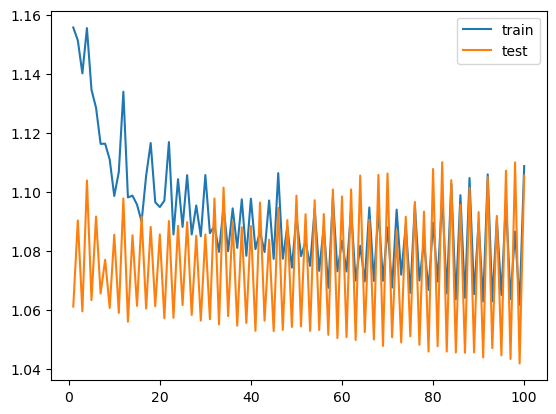

In [13]:
plt.plot(range(1,len(loss_array[0])+1),loss_array[0],label = "train")
plt.plot(range(1,len(loss_array[1])+1),loss_array[1],label= "test")
plt.legend()
plt.show()

In [24]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))

net_test.eval()

predict_probability = torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0]

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]

accuracy_score(real_results,predict_results)

0.4

In [22]:
act_predict_bool = (predict_results != 1) & (predict_probability > 0.42)

act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)

0.49333333333333335

In [23]:
act_predict_results.shape

torch.Size([75])

In [17]:
# saved_path = "./trained_model/Mix_LSTM.pth"

# torch.save(net_test.state_dict(),saved_path)